In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from flask import Flask, request, jsonify
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
# Load Dataset
df = pd.read_csv("data.csv")

In [7]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [8]:
df.shape

(4600, 18)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [10]:
df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [11]:
df.nunique()

date               70
price            1741
bedrooms           10
bathrooms          26
sqft_living       566
sqft_lot         3113
floors              6
waterfront          2
view                5
condition           5
sqft_above        511
sqft_basement     207
yr_built          115
yr_renovated       60
street           4525
city               44
statezip           77
country             1
dtype: int64

In [12]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [13]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

In [14]:
columns_to_remove = ['date', 'yr_renovated','street','city','statezip','country']
df = df.drop(columns=columns_to_remove)

In [15]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976


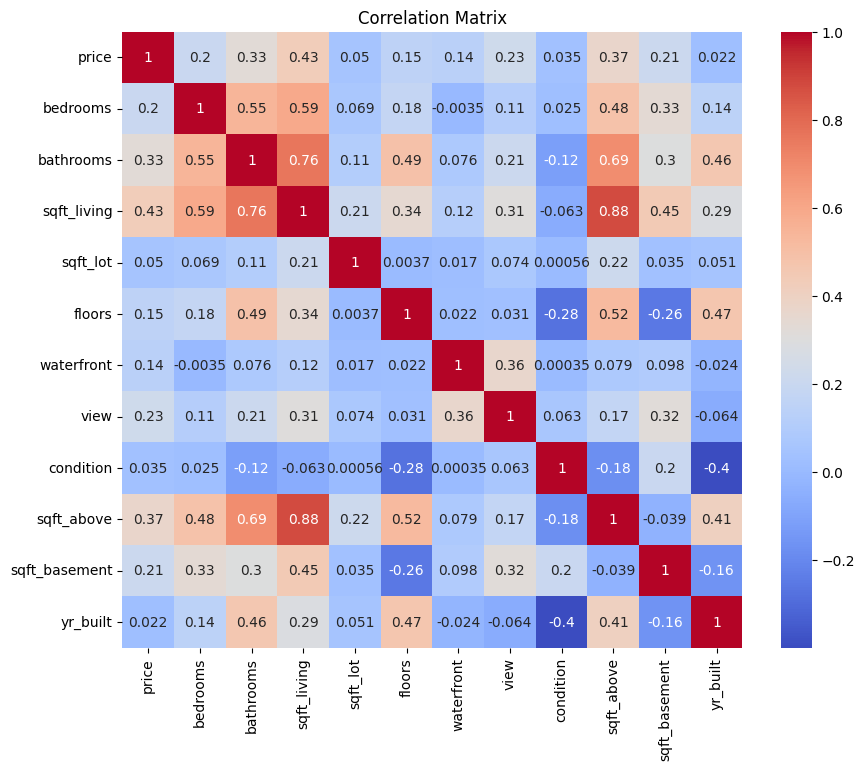

In [16]:
df_corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(df_corr, annot = True , cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [17]:
#removing outliers
import scipy.stats as stats
z_scores = stats.zscore(df)
threshold = 3
print("Size before removing outliers : ", df.shape)
outliers_df = df[(z_scores > threshold).any(axis = 1)]
df = df[(z_scores <= threshold).all(axis = 1)]
print("size after removing outliers :", df.shape)

Size before removing outliers :  (4600, 12)
size after removing outliers : (4244, 12)


In [18]:
outliers_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921
56,491500.0,4.0,1.75,2190,125452,1.0,0,2,3,2190,0,1968
100,736500.0,4.0,2.50,3180,21904,2.0,0,3,3,3180,0,2000
107,1090000.0,4.0,2.50,4340,141570,2.5,0,0,3,4340,0,1992
118,1030000.0,5.0,2.75,3190,16920,1.0,0,3,3,1690,1500,1976


In [19]:
# Handling Missing Values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

In [20]:
# Identify categorical and numerical columns
num_features = df.select_dtypes(include=['int64', 'float64']).columns
drop_target = 'price'  # Assuming 'price' is the target variable
num_features = num_features.drop(drop_target)
cat_features = df.select_dtypes(include=['object']).columns


In [21]:
# Encoding Categorical Features
cat_encoder = OneHotEncoder(handle_unknown='ignore')

In [22]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

In [23]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', num_imputer), ('scaler', scaler)]), num_features),
    ('cat', Pipeline([('imputer', cat_imputer), ('encoder', cat_encoder)]), cat_features)
])


In [24]:
# Splitting Data
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [25]:
print(f"'xtrain{X_train.shape}'")
print(f"'xtest{X_test.shape}'")

'xtrain(3183, 11)'
'xtest(1061, 11)'


In [26]:
# Define model
model_1 = XGBRegressor()
model_2 = LinearRegression()
model_3 = DecisionTreeRegressor()
model_4 = RandomForestRegressor()

In [27]:
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
print("Xgb regression")
print("Mean squared Error: ",mean_squared_error(y_test,y_pred))
print('\n')
print("Mean Absolute Error: ",mean_absolute_error(y_test,y_pred))
print('\n')
print("R Squared Error: ", r2_score(y_test,y_pred))
print('\n')

model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
print("Linear Regression")
print("Mean squared Error: ",mean_squared_error(y_test,y_pred_2))
print('\n')
print("Mean Absolute Error: ",mean_absolute_error(y_test,y_pred_2))
print('\n')
print("R Squared Error: ", r2_score(y_test,y_pred_2))
print('\n')

model_3.fit(X_train, y_train)
y_pred_3 = model_3.predict(X_test)
print("Decision Tree Regression ")
print("Mean squared Error: ",mean_squared_error(y_test,y_pred_3))
print('\n')
print("Mean Absolute Error: ",mean_absolute_error(y_test,y_pred_3))
print('\n')
print("R Squared Error: ", r2_score(y_test,y_pred_3))
print('\n')

model_4.fit(X_train, y_train)
y_pred_4 = model_4.predict(X_test)
print("Random Forest Regression ")
print("Mean squared Error: ",mean_squared_error(y_test,y_pred_4))
print('\n')
print("Mean Absolute Error: ",mean_absolute_error(y_test,y_pred_4))
print('\n')
print("R Squared Error: ", r2_score(y_test,y_pred_4))
print('\n')



Xgb regression
Mean squared Error:  46455671752.52388


Mean Absolute Error:  141257.32108059424


R Squared Error:  0.37713215383698107


Linear Regression
Mean squared Error:  41194072741.057686


Mean Absolute Error:  139590.95600748347


R Squared Error:  0.44767856334977363


Decision Tree Regression 
Mean squared Error:  75379330295.58344


Mean Absolute Error:  188094.75171257305


R Squared Error:  -0.010670157920384504


Random Forest Regression 
Mean squared Error:  44581653692.02975


Mean Absolute Error:  141827.250637607


R Squared Error:  0.4022585926328459




In [28]:
# Define the parameter grid
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.3, 0.7),
    'colsample_bytree': uniform(0.5, 1),
    'gamma': uniform(0, 0.5)
}


In [29]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    model_1,
    param_distributions=param_dist,
    n_iter=100,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)


In [30]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)


C:\Users\santh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
136 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\santh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\santh\AppData\Local\Packages\PythonSoftwareFoundat

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001ECCEA3EE40>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001ECCEEF91D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001ECCEA3EA50>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001ECCEEF9BD0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [31]:
# Get the best model and parameters
best_xgboost = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters: ", best_params)


Best Parameters:  {'colsample_bytree': np.float64(0.7962735057040824), 'gamma': np.float64(0.08263346953150125), 'learning_rate': np.float64(0.013127281348238786), 'max_depth': 3, 'n_estimators': 443, 'subsample': np.float64(0.5764170627228988)}


In [32]:
# Evaluate the best model
y_pred_best = best_xgboost.predict(X_test)
print("Optimized XGBoost Regression")
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred_best))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred_best))
print("R Squared Error: ", r2_score(y_test, y_pred_best))


Optimized XGBoost Regression
Mean Squared Error:  40380210047.12907
Mean Absolute Error:  135288.15921541094
R Squared Error:  0.4585906626503765


In [33]:
# Save the optimized XGBoost model using pickle
with open('best_xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(best_xgboost, model_file)


In [34]:
# Save the preprocessor using pickle
with open('preprocessor.pkl', 'wb') as preprocessor_file:
    pickle.dump(preprocessor, preprocessor_file)
